<a href="https://colab.research.google.com/github/miguel-fc/PyTorch-tools/blob/main/mlp_nr_v0_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Python related required packages
import io
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Number of labels
nl = 3
#Number of epochs
num_epochs = 200

In [ ]:
#Download dataloaders containing training, validation and test data for the MLP
!gdown "https://drive.google.com/uc?id=1zJPzEDRsqtJWtKKnaLAweNs2O2D3banH"
!gdown "https://drive.google.com/uc?id=1-44uc7wce6iyr-6jZqF_KvpyRT1U0E-_"
!gdown "https://drive.google.com/uc?id=1-0vJiyXciH_dycEwBAYj5pM5TVtTGfYI"
!gdown "https://drive.google.com/uc?id=11JUoHfBjRzCoWKldR42V3Jp7cbflPZG7"

Downloading...
From: https://drive.google.com/uc?id=1zJPzEDRsqtJWtKKnaLAweNs2O2D3banH
To: /content/mlp_train_loader.pth
100% 116k/116k [00:00<00:00, 76.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-44uc7wce6iyr-6jZqF_KvpyRT1U0E-_
To: /content/mlp_valid_loader.pth
100% 15.9k/15.9k [00:00<00:00, 34.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0vJiyXciH_dycEwBAYj5pM5TVtTGfYI
To: /content/mlp_test_loader.pth
100% 15.9k/15.9k [00:00<00:00, 35.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=11JUoHfBjRzCoWKldR42V3Jp7cbflPZG7
To: /content/mlp_test_dataset.pth
100% 15.3k/15.3k [00:00<00:00, 29.8MB/s]


In [ ]:
train_loader = torch.load('mlp_train_loader.pth')
valid_loader = torch.load('mlp_valid_loader.pth')
test_loader = torch.load('mlp_test_loader.pth')

test_dataset = torch.load('mlp_test_dataset.pth')

In [ ]:
#Defining a Multilayer Perceptron, MLP.
class MLP(nn.Module):

  def __init__(self,dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(d, 64),
      nn.ReLU(),
      nn.Linear(64, nl),
      # nn.ReLU(),
      # nn.Linear(32, nl),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# from torch.optim import optimizer
### Define the loss function 
loss_fn = torch.nn.MSELoss()

### Define the learning rate
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model 
model = MLP(dim=d)
params_to_optimize = [
    {'params': model.parameters()}
]

#Define the optimizer
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

#Checking the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cpu


In [ ]:
# Move model to device
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = []
    for data,label in dataloader: 
        img = data
        img = img.to(device)
        # print(img.shape)
        label = label.to(device)
        out_label = model(img)
        loss = loss_fn(out_label, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Valid function
def valid_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.to(device)
            label = label.to(device)
            out_label = model(img)
            list_decoded_img.append(out_label.cpu())
            list_img.append(label.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [ ]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
  val_loss = valid_epoch(model,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)


EPOCH 1/200 	 train loss 0.2475612610578537 	 val loss 0.023414574563503265
EPOCH 2/200 	 train loss 0.02140483818948269 	 val loss 0.022697119042277336
EPOCH 3/200 	 train loss 0.02144780196249485 	 val loss 0.02237066999077797
EPOCH 4/200 	 train loss 0.02121158130466938 	 val loss 0.02260614186525345
EPOCH 5/200 	 train loss 0.02099301479756832 	 val loss 0.021912340074777603
EPOCH 6/200 	 train loss 0.02101973257958889 	 val loss 0.022161366418004036
EPOCH 7/200 	 train loss 0.020983025431632996 	 val loss 0.021872656419873238
EPOCH 8/200 	 train loss 0.02086811326444149 	 val loss 0.022058069705963135
EPOCH 9/200 	 train loss 0.020710304379463196 	 val loss 0.022058842703700066
EPOCH 10/200 	 train loss 0.020645394921302795 	 val loss 0.02219463139772415
EPOCH 11/200 	 train loss 0.020589390769600868 	 val loss 0.02145245298743248
EPOCH 12/200 	 train loss 0.02051675319671631 	 val loss 0.0214395709335804
EPOCH 13/200 	 train loss 0.02059582807123661 	 val loss 0.02146404236555099

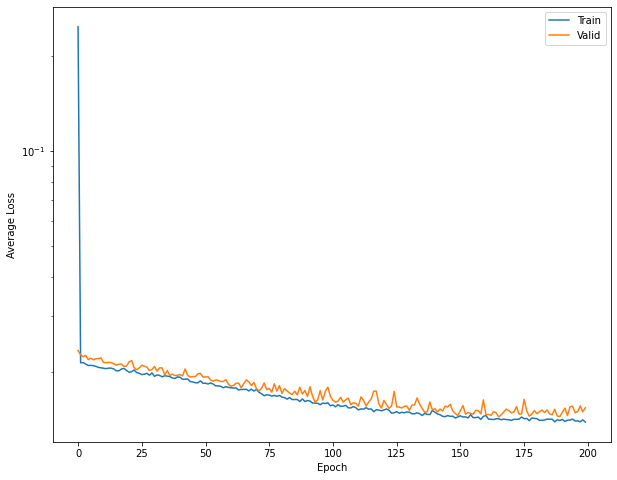

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
# #Seeing how the model performs for the test unseen data. For this we choose 10 figures
# #running through model.eval() and compute the loss plus we look at them visually

# #Similar to plot_ae_outputs, except that this is one used to see the loss for 
# #data in the test_loader. It also prints the loss for each
# def plot_test_outputs(model,dataset,device,n=10):
#     plt.figure(figsize=(26,5.5))
#     for i in range(10):
#       ax = plt.subplot(2,n,i+1)
#       img,_ = dataset[i]
#       #Notice that below i'm loading an image only, so it needs to be flatten
#       #before entering the network
#       img = torch.flatten(img).to(device)
#       encoder.eval().to(device)
#       decoder.eval().to(device)
#       with torch.no_grad():
#          decoded_img  = decoder(encoder(img))
#          loss = loss_fn(decoded_img,img)
#          print('For image {}, the loss = {}'.format(i,loss.data))
#       plt.plot(img.cpu().reshape(in_d1,in_d2).numpy()[0],img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
#       if i == n//2:
#         ax.set_title('Original images')
#       ax = plt.subplot(2, n, i + 1 + n) 
#       plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
#       if i == n//2:
#          ax.set_title('Reconstructed images')
#     plt.show()  


# plot_test_outputs(encoder,decoder,test_dataset,device,n=10)

In [ ]:
out_samples = []
for sample in test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nl):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples



,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.143372,-0.201610,-0.443218,0.185,-0.412,-0.58489
1,0.173155,0.403905,-0.242381,0.174,0.353,-0.54426
2,0.156574,0.367920,0.386328,0.122,0.0998,0.30727
3,0.077134,-0.196550,0.424039,0.0859,-0.507,0.55057
4,0.075671,0.353169,0.357479,0.0568,0.277,0.17738
...,...,...,...,...,...,...
590,0.173889,0.445433,-0.228281,0.193,0.591,-0.44723
591,0.172215,0.322249,-0.267809,0.179,0.249,-0.50584
592,0.092159,-0.310467,-0.347141,0.0866,-0.201,-0.20922
593,0.174371,0.533282,-0.202108,0.182,0.589,-0.5938


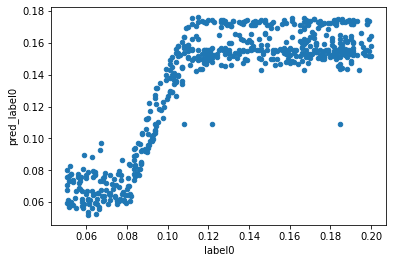

In [ ]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

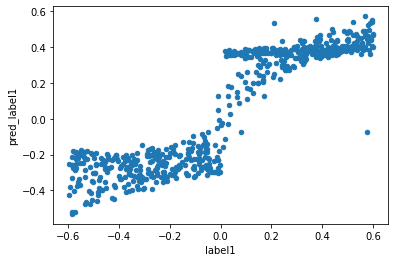

In [ ]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

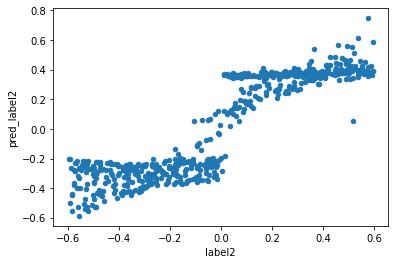

In [ ]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()